In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [17]:
predictions_dict = {}

In [18]:
config_filename = 'weights.yaml'
config = read_config(config_filename)

In [19]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
fetching from athenadb...
pulling from cache
loading from ../../misc/cache/dataframes_ts_19102020_athena.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 181                 | 182                 | 183                 | 184                 | 185                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| state       | Jharkhand           | Jharkhand           | Jharkhand           | Jharkhand           | Jharkhand           |
| district    | Ranchi              | Ranchi              | Ranchi              | Ranchi              | Ranchi              |
| date        | 2020-09-29 00:00:00 | 2020-09-30 00:00:00 | 2020-10-01 00:00:00 | 2020-10-02 00:00:00 | 2020-10-03 00:00:00 |
| total       | 18678.0             | 19004.0             | 19173.83   

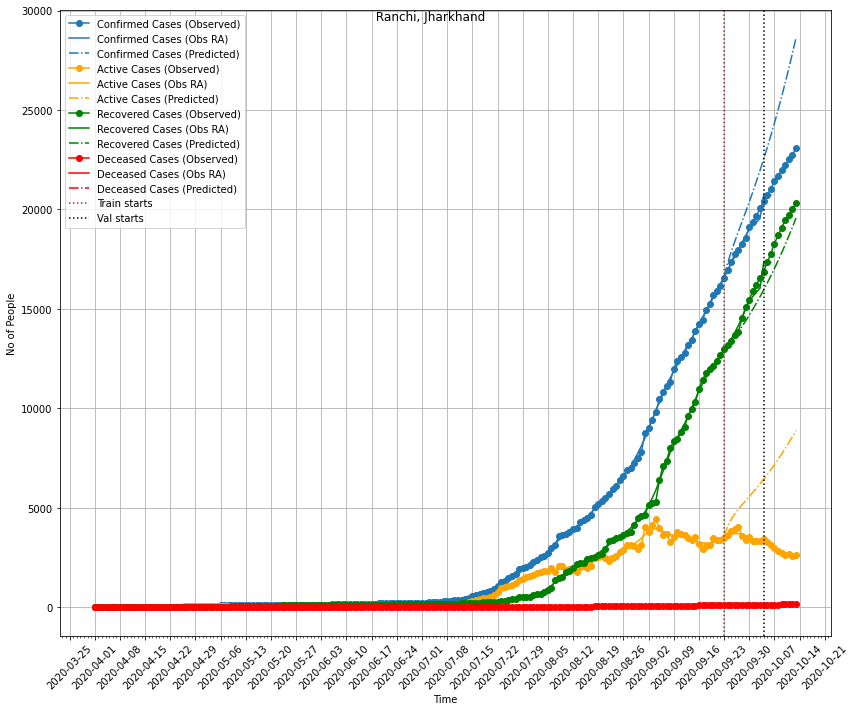

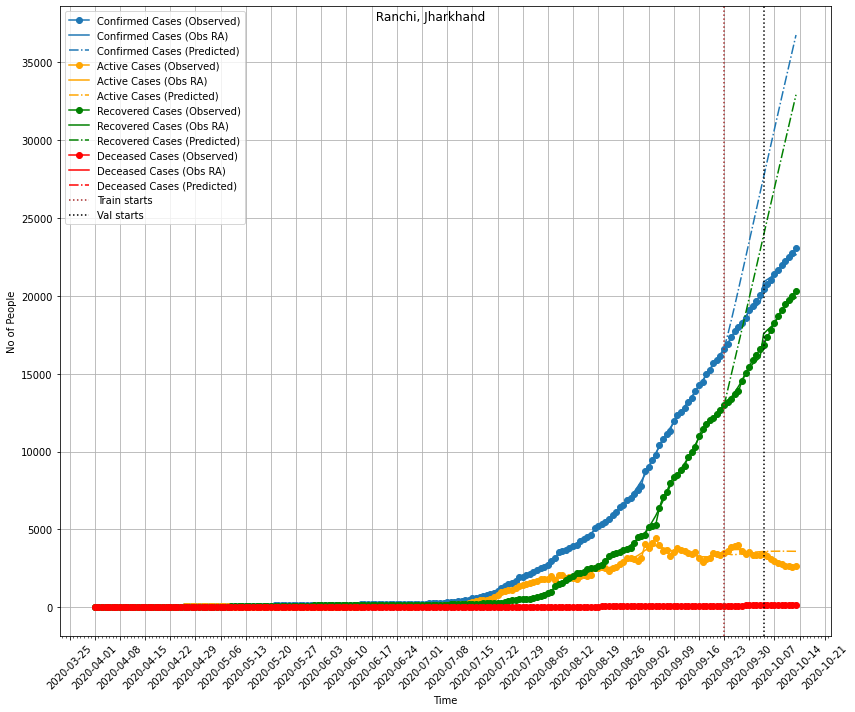

In [20]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 10
m2_params['split']['test_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)
# predictions_dict['m2'] = predictions_dict['m1']

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [21]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.19781444011890192,
 'I_hosp_ratio': 0.6816435076067777,
 'P_fatal': 0.006316614921661368,
 'T_inc': 4.981606700182422,
 'T_inf': 3.192693303189911,
 'T_recov': 18.83609047448042,
 'T_recov_fatal': 10.275738113129078,
 'lockdown_R0': 1.324437554111924}

In [22]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 1.4631596261579862,
 'I_hosp_ratio': 0.7998031235993929,
 'P_fatal': 0.01774408721851144,
 'T_inc': 4.163685878735923,
 'T_inf': 3.5421694032690216,
 'T_recov': 3.347753221448464,
 'T_recov_fatal': 24.7962270016777,
 'lockdown_R0': 0.9862890833189186}

## Loss Dataframes

### M1 Loss DataFrame

In [23]:
predictions_dict['m1']['df_loss']

train      val
total      5.48135  11.4945
active     42.7097  104.705
recovered  2.90669  5.91374
deceased   3.60127  3.61488

### M2 Loss DataFrame

In [24]:
predictions_dict['m2']['df_loss']

train      val
total      16.6917  47.6136
active      6.9255  25.7004
recovered  21.5073  51.1465
deceased   11.3437  45.4074

## Sensitivity Plot

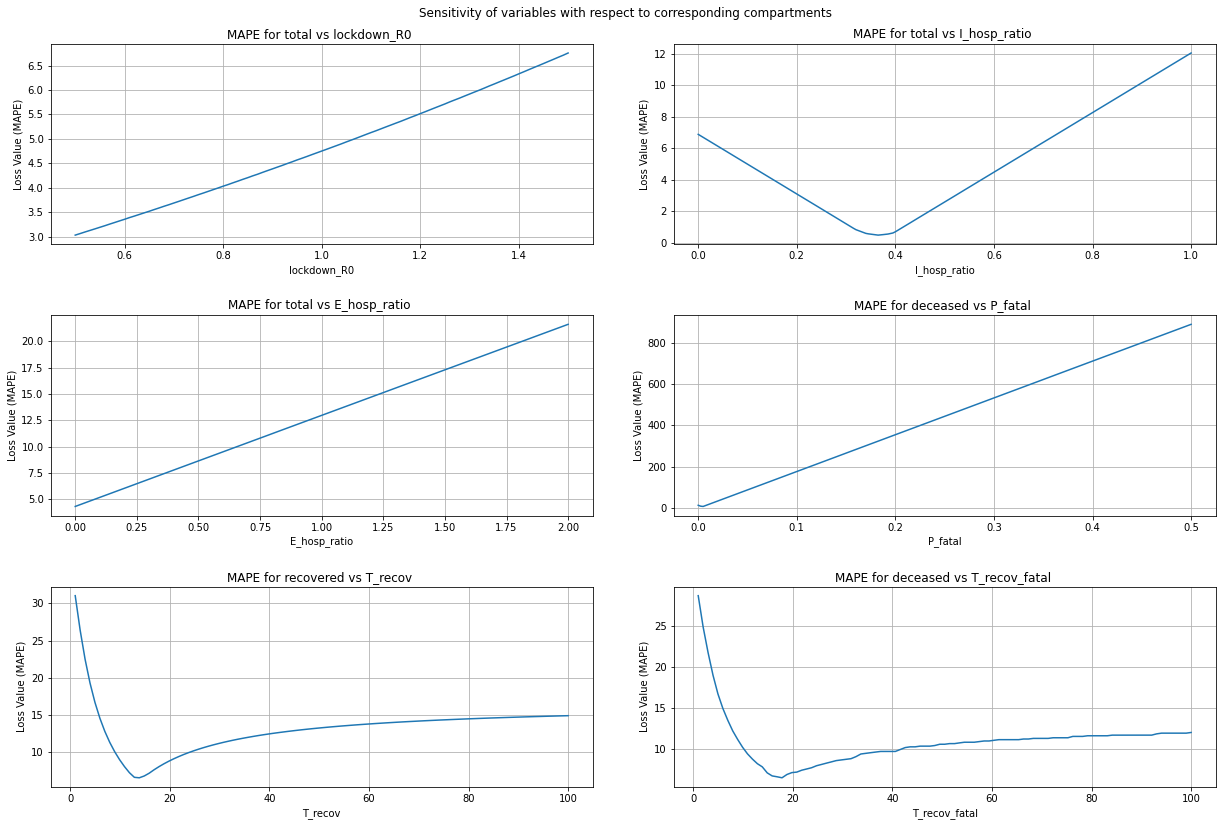

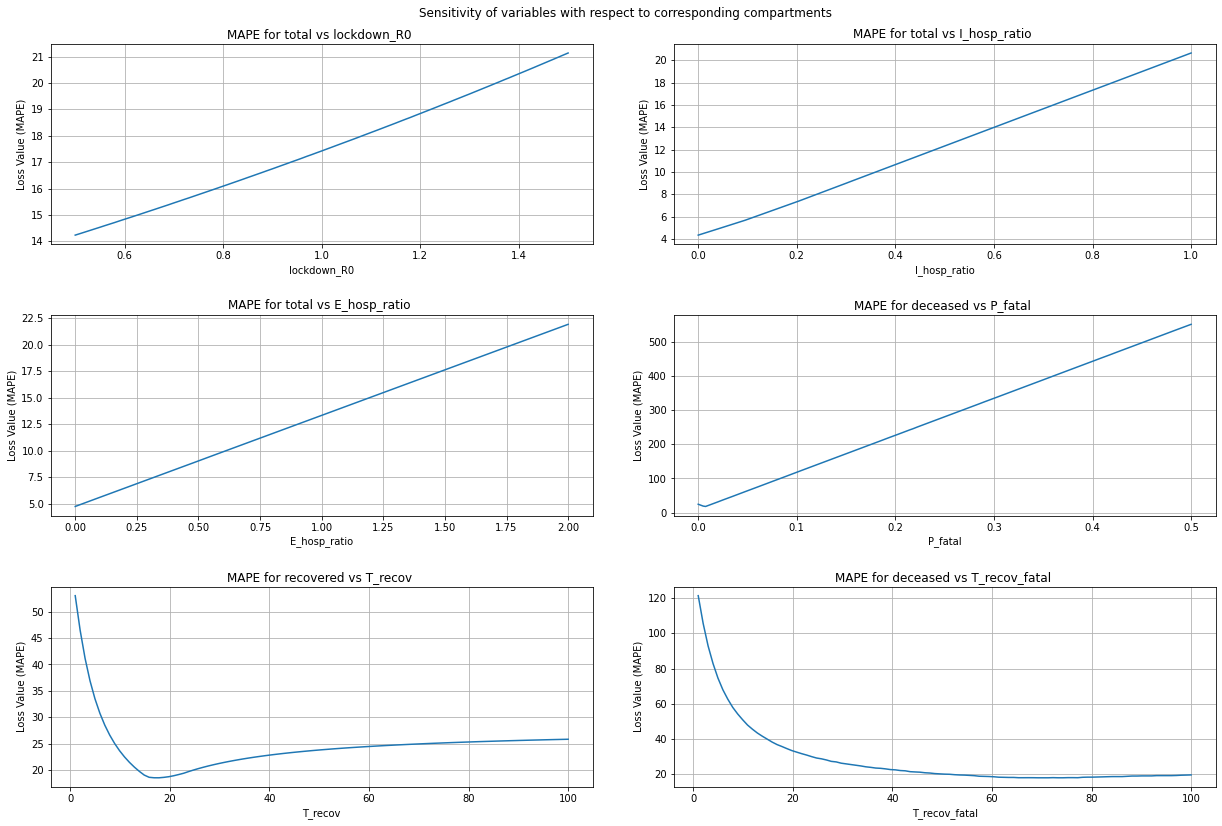

In [25]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [26]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


[         date        S     E     I  R_recov  R_fatal      C    D  active  \
0  2020-09-23  3275246  5255  2872     3528       63  12931  102    3591   
1  2020-09-24  3274399  4887  3222     3353       76  13955  105    3429   
2  2020-09-25  3273478  4663  3425     3288       89  14945  108    3377   
3  2020-09-26  3272515  4524  3543     3275      103  15924  112    3378   
4  2020-09-27  3271527  4438  3607     3288      116  16904  116    3404   
..        ...      ...   ...   ...      ...      ...    ...  ...     ...   
61 2020-11-23  3219020  3439  2977     2809      373  70559  821    3182   
62 2020-11-24  3218213  3422  2963     2795      372  71396  836    3167   
63 2020-11-25  3217410  3404  2948     2782      372  72229  851    3154   
64 2020-11-26  3216612  3387  2933     2768      372  73058  866    3140   
65 2020-11-27  3215818  3370  2919     2755      372  73883  881    3127   

    recovered  deceased  total  
0       12931       102  16624  
1       13955       

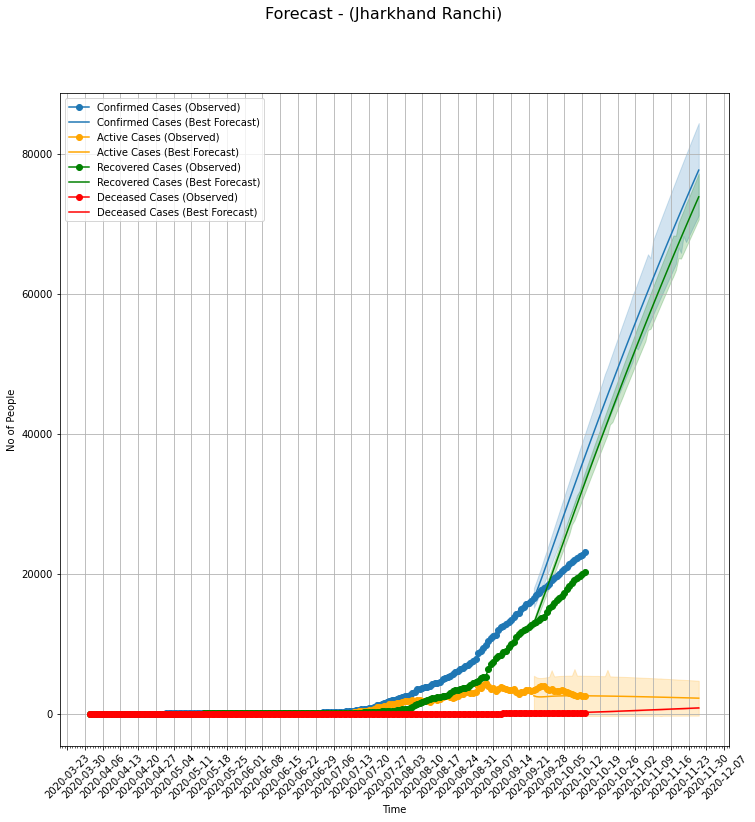

In [27]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [28]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

20it [00:00, 107.66it/s]getting forecasts ..



In [29]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

20it [00:00, 109.95it/s]getting forecasts ..



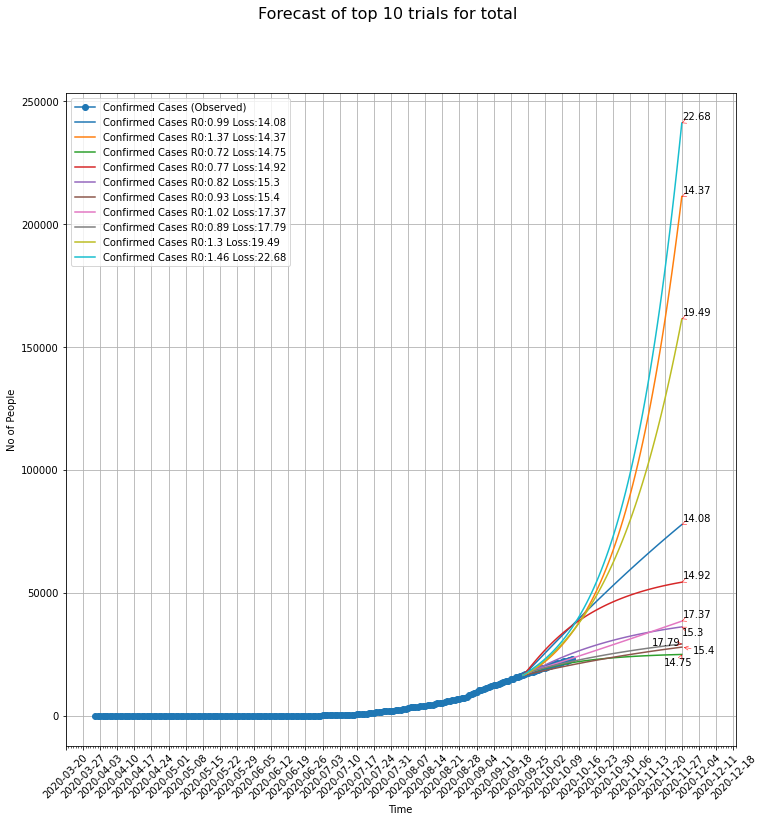

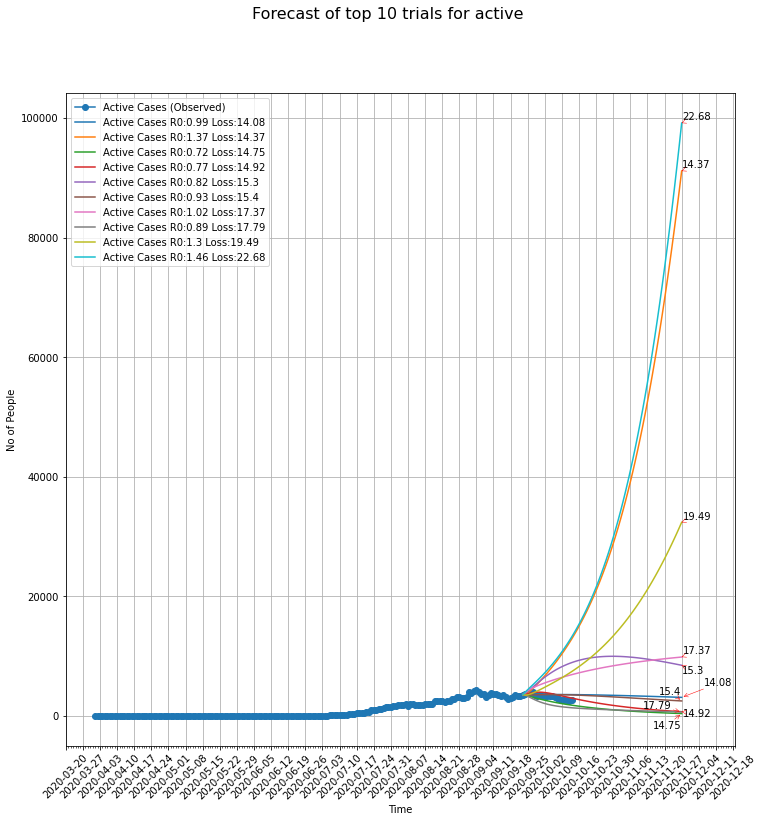

In [30]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [31]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [32]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:01<00:00, 59.64trial/s, best loss: 30.75408801270219]


In [33]:
uncertainty.beta_loss

{'active': 98.01451476541467,
 'recovered': 6.504183915782665,
 'deceased': 8.509685974405711,
 'total': 9.987967395205722}

In [34]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [35]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

67810  18130  10555    38135      160  64693  513   38295   
63 2020-11-25  3163543  18701  10892    39414      166  66752  529   39580   
64 2020-11-26  3159146  19285  11239    40731      171  68880  545   40902   
65 2020-11-27  3154616  19884  11594    42085      177  71078  562   42262   

    recovered  deceased   total  daily_cases  
8       14986       123   20888        512.0  
9       15297       126   21417        529.0  
10      15620       128   21962        545.0  
11      15954       131   22527        565.0  
12      16301       134   23112        585.0  
13      16660       137   23717        605.0  
14      17032       141   24346        629.0  
15      17419       144   24997        651.0  
16      17819       147   25672        675.0  
17      18233       151   26370        698.0  
18      18663       154   27094        724.0  
19      19108       158   27844        750.0  
20      19570       161   28621        777.0  
21      20048       165   29428        807.0  

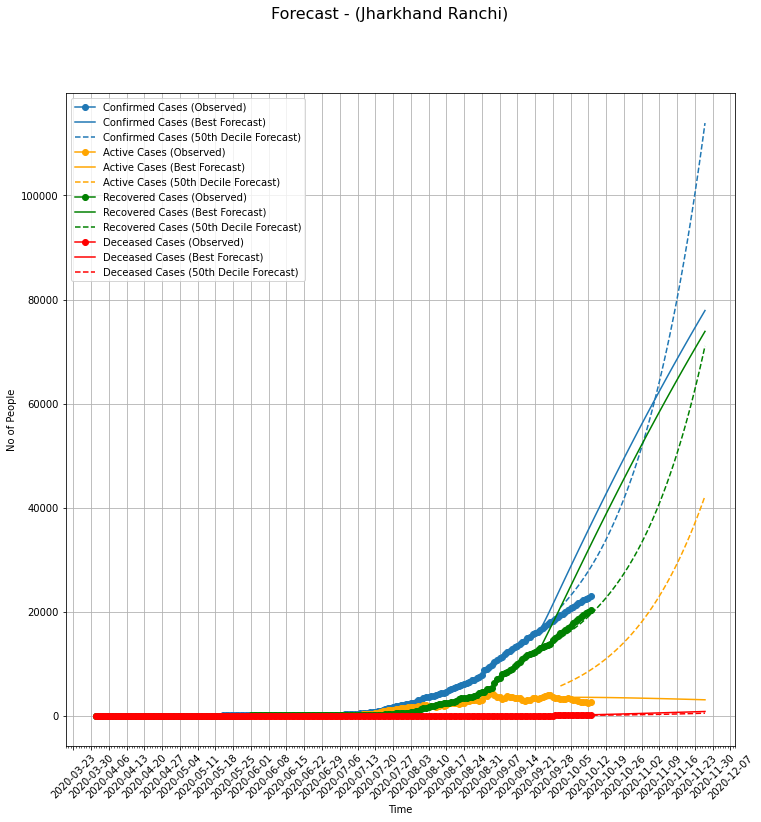

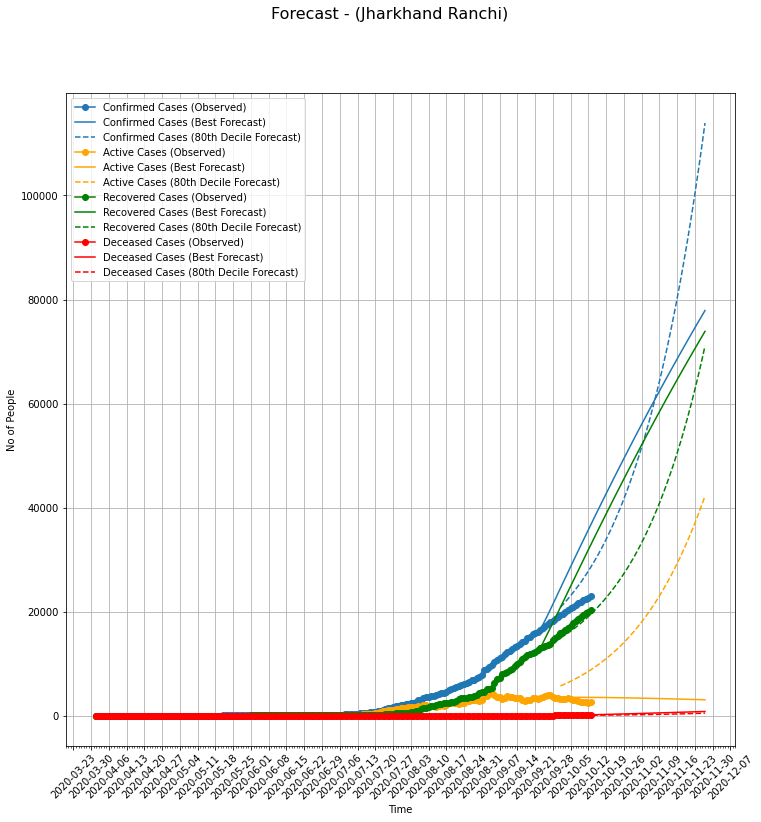

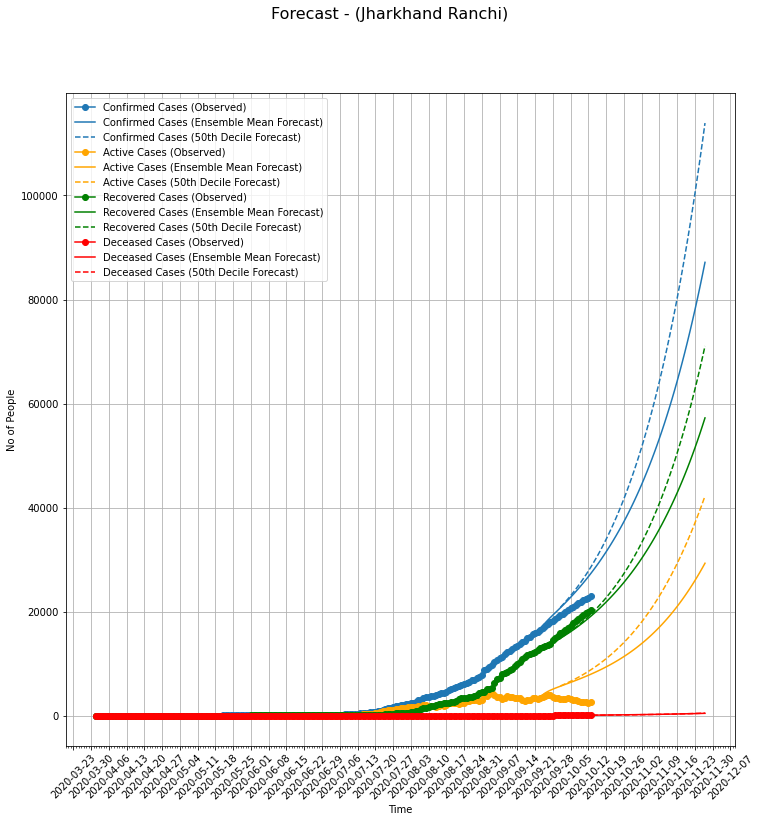

In [36]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

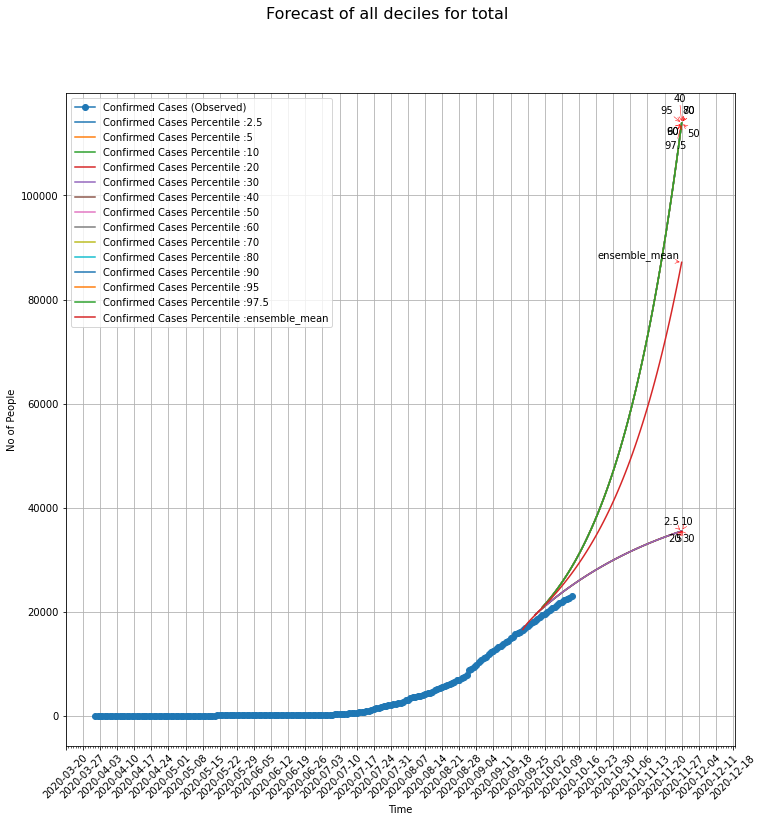

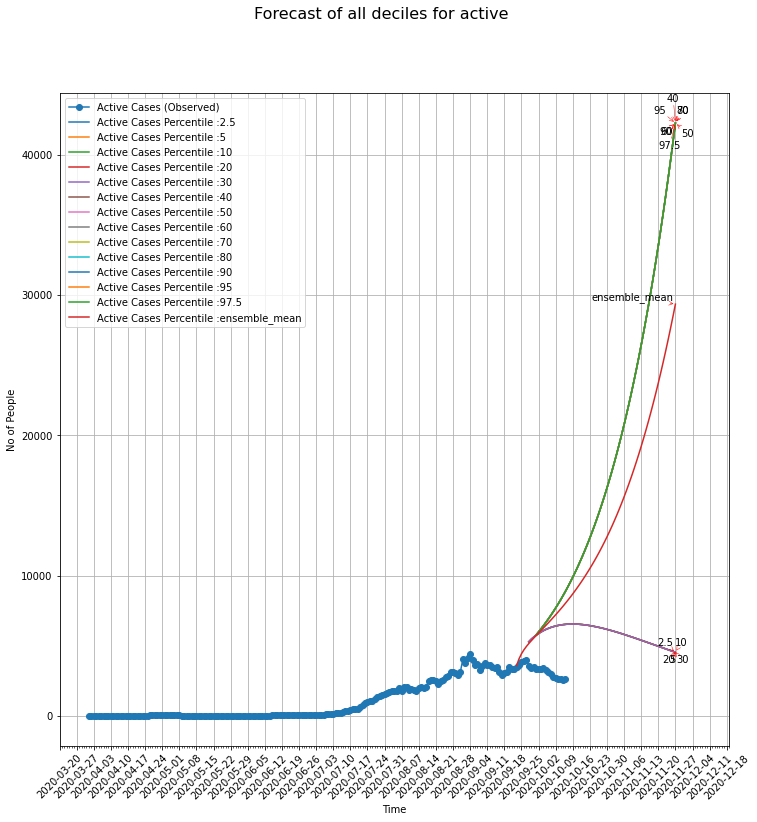

In [37]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


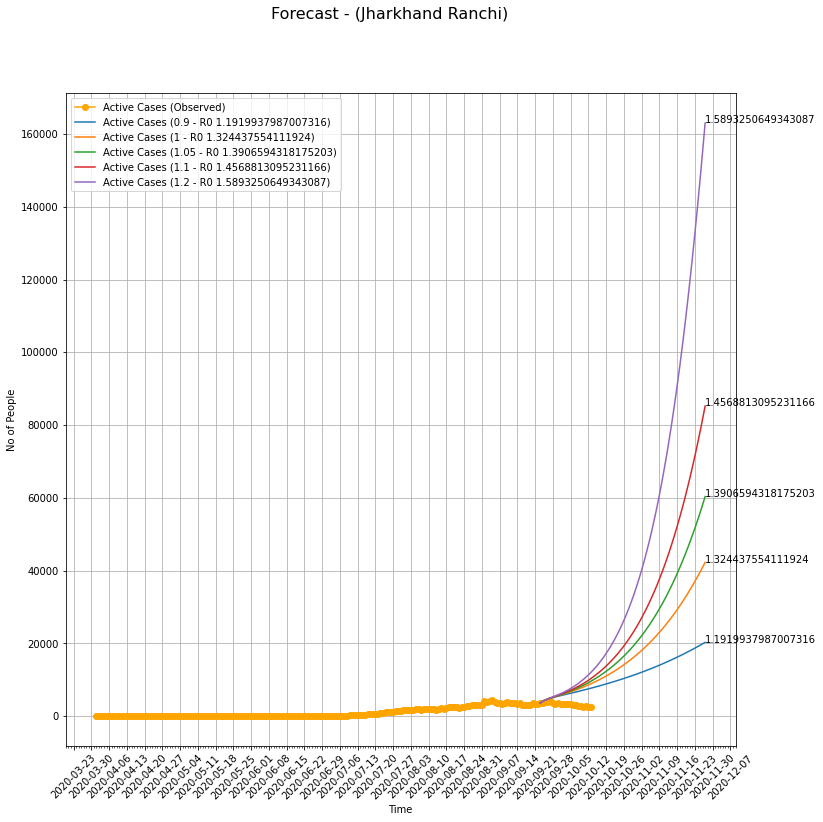

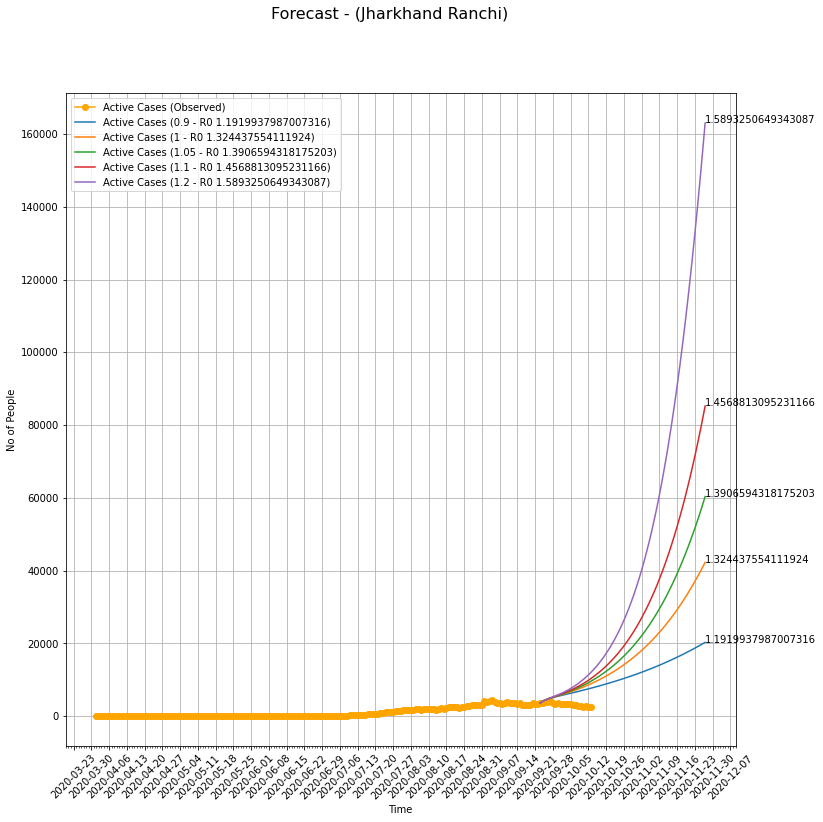

In [38]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_mul_dict = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
plot_r0_multipliers(predictions_dict, None, predictions_mul_dict, None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Create Report

In [39]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [40]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [41]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [42]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Create R0 Multiplier Output

In [43]:
save_r0_mul(predictions_mul_dict, output_folder)

## Create df_district Output

In [44]:
predictions_dict['m1']['df_district'].to_csv(f'{output_folder}/df_district.csv')

## Experiments

In [45]:
predictions_dict['m1'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'df_district_unsmoothed', 'run_params', 'trials_processed'])

In [46]:
predictions_dict['m2'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'df_district_unsmoothed', 'run_params', 'forecasts', 'trials_processed', 'beta', 'beta_loss', 'deciles'])

In [47]:
predictions_dict['m2']['df_district']

state district       date  total  active  recovered  deceased  \
0    Jharkhand   Ranchi 2020-04-01      1       1          0         0   
1    Jharkhand   Ranchi 2020-04-02      1       1          0         0   
2    Jharkhand   Ranchi 2020-04-03      1       1          0         0   
3    Jharkhand   Ranchi 2020-04-04      1       1          0         0   
4    Jharkhand   Ranchi 2020-04-05      1       1          0         0   
..         ...      ...        ...    ...     ...        ...       ...   
191  Jharkhand   Ranchi 2020-10-09  21975    2749      19083       143   
192  Jharkhand   Ranchi 2020-10-10  22245    2627      19474       144   
193  Jharkhand   Ranchi 2020-10-11  22531    2669      19718       144   
194  Jharkhand   Ranchi 2020-10-12  22730    2557      20026       147   
195  Jharkhand   Ranchi 2020-10-13  23094    2628      20315       151   

     daily_cases  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
..           ...  
191        314.0  
192        270.0  
193        286.0  
194        199.0  
195        364.0  

[196 rows x 8 columns]

In [48]:
from utils.fitting.data_weights import Data_Weights

In [49]:
weights = config['fitting']['data_weights']['weights']

In [50]:
start_date = config['fitting']['data_weights']['start_date']
end_date = config['fitting']['data_weights']['end_date']

In [51]:
df_district = predictions_dict['m1']['df_district']

In [52]:
df_data_weights = Data_Weights.make_weights_df(0, df_district, start_date, end_date, weights)

         state district       date  total  active  recovered  deceased  \
0    Jharkhand   Ranchi 2020-04-01      1       1          0         0   
1    Jharkhand   Ranchi 2020-04-02      1       1          0         0   
2    Jharkhand   Ranchi 2020-04-03      1       1          0         0   
3    Jharkhand   Ranchi 2020-04-04      1       1          0         0   
4    Jharkhand   Ranchi 2020-04-05      1       1          0         0   
..         ...      ...        ...    ...     ...        ...       ...   
191  Jharkhand   Ranchi 2020-10-09  21975    2749      19083       143   
192  Jharkhand   Ranchi 2020-10-10  22245    2627      19474       144   
193  Jharkhand   Ranchi 2020-10-11  22531    2669      19718       144   
194  Jharkhand   Ranchi 2020-10-12  22730    2557      20026       147   
195  Jharkhand   Ranchi 2020-10-13  23094    2628      20315       151   

     daily_cases  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [53]:
start_date, end_date, train_period, val_period, test_period = config['fitting']['split'].values()

In [54]:
weights_dataframes = Data_Weights.implement_split(0, df_data_weights, train_period,val_period, test_period, start_date, end_date)

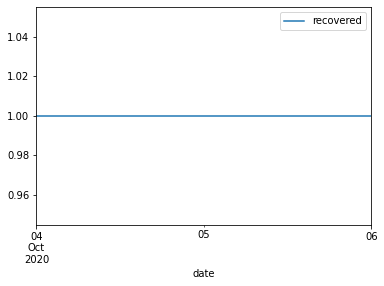

In [55]:
df_data_weights_val.plot(x='date', y='recovered')